In [1]:
%matplotlib widget
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button
import numpy as np
import json
from stereovision.calibration import StereoCalibrator
from stereovision.calibration import StereoCalibration
import ipywidgets as wg
from IPython.display import display
import seaborn as sns 
from PIL import Image

In [3]:
# Constants
photo_width = 3840
photo_height = 1440
focal_length = 512
bases = [2.5625]
colors = ['#f54242']
exp_distances = [41.5,51.5,61.5,71.5,81.5,106.5,126.5,146.5]

#Directories
SCENEDIRS = ['./scenesD']
CALIBDIRS = ['calib_resultD']

image_height = photo_height
image_width = int(photo_width/2)

In [4]:
# Defining functions
def generateBinaryImg(I):
    I = I[0:photo_height, 0:image_width, :]
    I_intensity = (I[:,:,1] > 100) # identify pixels with low GREEN values - they are less reliable
    I_cr = I[:,:,2]/I[:,:,1]  # This is the ratio of Red (0) to Green (1)
    I_cr[~I_intensity] = 1.0    # small green values would have infinite or near infinite ratios, replace with a "big" number instead for visualization
    I_sig = (I[:,:,2] > 1.2*I[:,:,1]) & I_intensity # Create image identifying flames on brightness & color basis
#     I_sig = (I[:,:,2]>220) & (I[:,:,2]<256)
#     I_sig = (I_cr>1.1)
    I_sig = np.uint8(I_sig)
    I_processed = cv2.morphologyEx(I_sig, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4)))
    return I_processed

def calculateDistance(avg_disparity):
    return (base_offset*focal_length)/avg_disparity

def getObjectDisparity(bin_img, disparity):
    obj_disparity = np.where(bin_img, disparity,0) #replace all fire pixels with disparity values
    obj_disparity = np.delete(obj_disparity,np.where(~obj_disparity.any(axis=1))[0], axis=0)
    obj_disparity = np.delete(obj_disparity,np.where(~obj_disparity.any(axis=0))[0], axis=1)
    return obj_disparity
def getDisparity(img_path):
    pair_img = cv2.imread(img_path,0)
    imgLeft = pair_img[0:photo_height, 0:image_width]  # Y+H and X+W
    imgRight = pair_img[0:photo_height, image_width:photo_width]  # Y+H and X+W
    rectified_pair = calibration.rectify((imgLeft, imgRight))
    sbm = cv2.StereoBM_create(numDisparities=48, blockSize=9)
    disparity = sbm.compute(rectified_pair[0], rectified_pair[1])
#     disparity = np.absolute(disparity)
#     local_max = disparity.max()
#     local_min = disparity.min()
#     disparity_visual = (disparity - local_min) * (1.0 / (local_max - local_min))
    return disparity#disparity_visual*255


In [5]:
def calculateArea(bin_img, depth):
    x,y,w,h = cv2.boundingRect(bin_img)
    cam_mat = calibration.cam_mats['left']
    u0 = cam_mat[0][2]
    v0 = cam_mat[1][2]
    fx = cam_mat[0][0]
    fy = cam_mat[1][1]
    u1 = x*fx/depth + u0
    v1 = y*fy/depth + v0
    u2 = (x+w)*fx/depth +u0
    v2 = (y+h)*fy/depth +v0
    img_coord1 = np.array([[u1,v1]])
    img_coord2 = np.array([[u2,v2]])
    rotation = calibration.rot_mat
    translation = calibration.trans_vec
#     world_coord1 = np.dot(img_coord1, np.linalg.inv(cam_mat))-translation.T
    world_coord1 = np.dot(img_coord1-translation.T, np.linalg.inv(cam_mat))
    world_coord1 = np.dot(world_coord1, np.linalg.inv(rotation))
#     world_coord2 = np.dot(img_coord2, np.linalg.inv(cam_mat))-translation.T
    world_coord2 = np.dot(img_coord2-translation.T, np.linalg.inv(cam_mat))
    world_coord2 = np.dot(world_coord2, np.linalg.inv(rotation))
    area = abs((world_coord2[0][0]-world_coord1[0][0])*(world_coord2[0][1]-world_coord1[0][1]))
    return 0.095*area    

In [6]:
## START
import numpy.linalg as la

def img2world(uv,cam_mat,rotation, translation, depth):

    s = rotation[2,2]*depth + translation[2] # Warning: Neglects x,y influence on depth through rotation matrix.

                                        # This seems OK because image is relatively centered and facing camera

                                        #

                                        # There might be a better way to specify s

    f = cam_mat[0:2,0:2]  # creat a smaller matrix from the camera matrix

    c = cam_mat[0:2,2]  # cx & cy - possibly incorrect indices

    M = np.outer(c, rotation[0:2,2])  # cast dot product of two vectors into an equivalent matrix

    F = f.dot(rotation[0:2,0:2]) + M  # combine like terms to save space and make it human readable

    F_inv = la.inv(F)  # pre-calc inverse

    xy = F_inv.dot(s*uv - c*(rotation[2,2]*depth+translation[2]) - f.dot(translation[0:2]) ) # solve.
    return xy 

In [7]:
def calculateArea(bin_img, depth):

    x,y,w,h = cv2.boundingRect(bin_img)

    cam_mat = calibration.cam_mats['left']

    world_coord1 = img2world(uv = np.array([x, y]), # line 32

                         cam_mat = cam_mat,

                         rotation = calibration.rot_mat,

                         translation = calibration.trans_vec,

                         depth = depth)

    world_coord2 = img2world(uv = np.array([x+w, y+h]), # only part different from line 32

                         cam_mat = cam_mat,

                         rotation = calibration.rot_mat,

                         translation = calibration.trans_vec,

                         depth = depth)
    print((world_coord2[0][1]-world_coord1[0][1])/(world_coord2[0][0]-world_coord1[0][0]))
    
    area = abs((world_coord2[0][0]-world_coord1[0][0])*(world_coord2[0][1]-world_coord1[0][1]))
    return area   

In [8]:
print(calibration.cam_mats['left'])
print(11.5/9.25)

NameError: name 'calibration' is not defined

In [10]:

D1 = np.zeros((image_height,image_width), "uint8")
D1[221:650,783:1130] =  1

D2 = np.zeros((image_height,image_width), "uint8")
D2[295:642,725:998] =  1

D3 = np.zeros((image_height,image_width), "uint8")
D3[350:640,768:998] =  1

D4 = np.zeros((image_height,image_width), "uint8")
D4[393:638,795:998] =  1

D5 = np.zeros((image_height,image_width), "uint8")
D5[416:630,834:1013] =  1

D6 = np.zeros((image_height,image_width), "uint8")
D6[506:674,908:1041] =  1

D7 = np.zeros((image_height,image_width), "uint8")
D7[525:665,935:1045] =  1

D8 = np.zeros((image_height,image_width), "uint8")
D8[540:661,938:1036] =  1

binaries = [D1,D2,D3,D4,D5,D6,D7,D8]



In [11]:
fig, ax = plt.subplots()
count = 0
total = 0
tolerance = 25 #threshold distance should be within +/
min_dist, max_dist = 0,0
total_area = 0
for i in range(1):
    SCENEDIR = SCENEDIRS[i]
    CALIBDIR = CALIBDIRS[i]
    calibration = StereoCalibration(input_folder = CALIBDIR)
    base_offset = bases[i]
    j=0
    for folder in os.listdir(SCENEDIR):
        expected_dist = exp_distances[j]
        bin_img = binaries[j]
        j=j+1
        for img_path in os.listdir(os.path.join(SCENEDIR,folder)):
            full_path = os.path.join(SCENEDIR,folder,img_path)
            disparity = getDisparity(full_path)
            obj_disparity = getObjectDisparity(bin_img, disparity)
            mean_object_disparity = np.mean(obj_disparity) #np.sum(obj_disparity)/np.count_nonzero(obj_disparity) #
            obj_distance = calculateDistance(mean_object_disparity)
            area = calculateArea(bin_img, obj_distance)
            total_area+=area
#             print(area)
            if obj_distance > expected_dist - tolerance and obj_distance < expected_dist + tolerance:
                color = "#d19fe8"
                count = count+1
            else:
                color = colors[i]
#             color = colors[i]
            plt.scatter(expected_dist, obj_distance, marker = 'o', c = color)
#             plt.scatter(expected_dist, area, marker = 'o', c = color)
            total = total+1
#             if obj_distance>max_dist:
#                 max_dist = int(obj_distance)
#             elif obj_distance<min_dist:
#                 min_dist = int(obj_distance)
# print("mean area: ", str(total_area/total))
# ax.plot(range(40, 150), [9.25*11.5]*110, '-b', linewidth=1)
ax.plot(range(0,160), range(0,160), '-b', linewidth=1)
config1 = plt.scatter(None, None, marker = 'o', c = "#d19fe8")
config2 = plt.scatter(None, None, marker = 'o', c = colors[0])

plt.legend([config1, config2], ['within 25" of actual dist', 'more than 25" off from actual dist'])
ax.set_ylabel("Measured Distance (inches)")
ax.set_xlabel("Expected Distance (inches)")
# ax.set_ylabel("Measured Area (inches^2)")
# ax.set_xlabel("Expected Distance (inches)")
ax.set_title("Object Distance Measurement from Stereo Camera")
# ax.set_title("Object Area Measurement from Stereo Camera")

print("count: ", count)
print("percent correct: ", str(count/total))
# plt.xlim(0,250)
# plt.ylim(0,130)
plt.show()
fig.savefig('imageD.png', dpi = 300, bbox_inches = 'tight', transparent = False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1.236311239193083
1.2363112391930835
1.2363112391930837
1.2363112391930835
1.236311239193084
1.2363112391930835
1.2710622710622712
1.271062271062271
1.2710622710622714
1.2710622710622712
1.2710622710622717
1.2710622710622708
1.2608695652173905
1.2608695652173916
1.2608695652173916
1.2608695652173916
1.260869565217391
1.2608695652173916
1.2068965517241383
1.2068965517241377
1.2068965517241381
1.2068965517241386
1.2068965517241377
1.2068965517241375
1.2068965517241386
1.2068965517241381
1.1955307262569839
1.1955307262569823
1.1955307262569832
1.1955307262569845
1.1955307262569836
1.1955307262569839
1.195530726256983
1.1955307262569828
1.263157894736842
1.2631578947368427
1.2631578947368431
1.2631578947368436
1.263157894736841
1.2631578947368414
1.2727272727272732
1.272727272727273
1.2727272727272727
1.2727272727272712
1.272727272727273
1.2727272727272723
1.2346938775510206
1.2346938775510183
1.2346938775510203
1.23469387755102
1.2346938775510201
1.2346938775510203
count:  34
percent corr

In [38]:
print(9.25*11.5)

106.375


In [12]:
def getDisparity(img_path, numDisp, blkSize):
    pair_img = cv2.imread(img_path,0)
    imgLeft = pair_img[0:photo_height, 0:image_width]  # Y+H and X+W
    imgRight = pair_img[0:photo_height, image_width:photo_width]  # Y+H and X+W
    rectified_pair = calibration.rectify((imgLeft, imgRight))
    sbm = cv2.StereoBM_create(numDisparities=numDisp, blockSize=blkSize)
    disparity = sbm.compute(rectified_pair[0], rectified_pair[1])
#     disparity = np.absolute(disparity)
#     local_max = disparity.max()
#     local_min = disparity.min()
#     disparity_visual = (disparity - local_min) * (1.0 / (local_max - local_min))
    return disparity#disparity_visual*255

In [13]:
SIZES = [5, 7, 9, 11, 13, 15,17, 19, 21]
NUMDISPARITIES = [16, 32, 48, 64]
colors = ['#f54242', '#42f578', '#42a7f5', "#d19fe8"]
fig, ax = plt.subplots()
count = 0
total = 0
tolerance = 25 #threshold distance should be within +/
min_dist, max_dist = 0,0
for size in SIZES:
    for k in range(len(NUMDISPARITIES)):
        color = colors[k]
        for i in range(1):
            SCENEDIR = SCENEDIRS[i]
            CALIBDIR = CALIBDIRS[i]
            calibration = StereoCalibration(input_folder = CALIBDIR)
            base_offset = bases[i]
            j=0
            for folder in os.listdir(SCENEDIR):
                expected_dist = exp_distances[j]
                bin_img = binaries[j]
                j=j+1
                for img_path in os.listdir(os.path.join(SCENEDIR,folder)):
                    full_path = os.path.join(SCENEDIR,folder,img_path)
                    disparity = getDisparity(full_path, NUMDISPARITIES[k], size)
                    obj_disparity = getObjectDisparity(bin_img, disparity)
                    mean_object_disparity = np.mean(obj_disparity) #np.sum(obj_disparity)/np.count_nonzero(obj_disparity) #
                    obj_distance = calculateDistance(mean_object_disparity)

                    if obj_distance > expected_dist - tolerance and obj_distance < expected_dist + tolerance:
                        count = count+1
                    total = total+1
                    if obj_distance>max_dist:
                        max_dist = int(obj_distance)
                    elif obj_distance<min_dist:
                        min_dist = int(obj_distance)
#         print(count)
        plt.scatter(size, count, marker = 'o', c = color)
        count = 0
config1 = plt.scatter(None, None, marker = 'o', c = colors[0])
config2 = plt.scatter(None, None, marker = 'o', c = colors[1])
config3 = plt.scatter(None, None, marker = 'o', c = colors[2])
config4 = plt.scatter(None, None, marker = 'o', c = colors[3])

plt.legend([config1, config2, config3, config4], [NUMDISPARITIES[0], NUMDISPARITIES[1], NUMDISPARITIES[2],NUMDISPARITIES[3]])
ax.set_ylabel("# Correct Measurements")
ax.set_xlabel("Block Size")
ax.set_title("Effect of Disparity Settings on Distance Measurements")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 

In [14]:
#choose camera configuration & calibrate
i = 0
SCENEDIR = SCENEDIRS[i]
CALIBDIR = CALIBDIRS[i]
BINARY = binaries
scenes = os.listdir(SCENEDIR)
print(scenes)
calibration = StereoCalibration(input_folder = CALIBDIR)

#chose distance and image
j = 0
folder = scenes[j]
bin_img = BINARY[j]
images = os.listdir(os.path.join(SCENEDIR,folder))
image = images[0]
img_path = os.path.join(SCENEDIR,folder,image)

pair_img = cv2.imread(img_path, 0)
imgLeft = pair_img[0:photo_height, 0:image_width]  # Y+H and X+W
imgRight = pair_img[0:photo_height, image_width:photo_width]  # Y+H and X+W
rectified_pair = calibration.rectify((imgLeft, imgRight))
fig, ax = plt.subplots()
I = cv2.imread(img_path)
disparity = getDisparity(img_path)
print(img_path)
imgLeft = I[0:photo_height, 0:image_width, :]  # Y+H and X+W

ax.get_yaxis().set_visible(False) 
ax.get_xaxis().set_visible(False) 
imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2RGB)


plt.imshow(imgLeft)
fig.savefig('imageD.png', dpi = 300, bbox_inches = 'tight', transparent = False)
print(imgLeft.shape)

['1', '2', '3', '4', '5', '6', '7', '8']


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: getDisparity() missing 2 required positional arguments: 'numDisp' and 'blkSize'

In [15]:
fig, ax = plt.subplots()

obj_disparity = getObjectDisparity(bin_img, disparity)

sns.distplot(obj_disparity, ax= ax,hist = True,norm_hist = False, kde = False)
mean_object_disparity = np.sum(obj_disparity)/np.count_nonzero(obj_disparity)#np.mean(obj_disparity)
obj_distance = calculateDistance(mean_object_disparity)
print("distance: ", obj_distance)
print("mean: ",mean_object_disparity)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

distance:  40.441668155162475
mean:  32.44178739032851


In [16]:
# Depth map function
SWS = 5
PFS = 5
PFC = 29
MDS = -25
NOD = 128
TTH = 100
UR = 10
SR = 15
SPWS = 100

def stereo_depth_map(rectified_pair):
    c, r = rectified_pair[0].shape
    disparity = np.zeros((c, r), np.uint8)
    sbm = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    sbm.setPreFilterType(1)
    sbm.setPreFilterSize(PFS)
    sbm.setPreFilterCap(PFC)
    sbm.setMinDisparity(MDS)
    sbm.setNumDisparities(NOD)
    sbm.setTextureThreshold(TTH)
    sbm.setUniquenessRatio(UR)
    sbm.setSpeckleRange(SR)
    sbm.setSpeckleWindowSize(SPWS)
    disparity = sbm.compute(rectified_pair[0], rectified_pair[1])
    local_max = disparity.max()
    local_min = disparity.min()
    disparity_visual = (disparity - local_min) * (1.0 / (local_max - local_min))
    local_max = disparity_visual.max()
    local_min = disparity_visual.min()
    return disparity_visual

disparity = stereo_depth_map(rectified_pair)
# Set up and draw interface
# Draw left image and depth map
axcolor = 'lightgoldenrodyellow'
fig = plt.subplots(1, 2)
plt.subplots_adjust(left=0.15, bottom=0.5)
plt.subplot(1, 2, 1)
dmObject = plt.imshow(rectified_pair[0], 'gray')

saveax = plt.axes([0.3, 0.38, 0.15, 0.04])  # stepX stepY width height
buttons = Button(saveax, 'Save settings', color=axcolor, hovercolor='0.975')
def save_map_settings(event):
    buttons.label.set_text("Saving...")
    print('Saving to file...')
    result = json.dumps({'SADWindowSize': SWS, 'preFilterSize': PFS, 'preFilterCap': PFC, \
                         'minDisparity': MDS, 'numberOfDisparities': NOD, 'textureThreshold': TTH, \
                         'uniquenessRatio': UR, 'speckleRange': SR, 'speckleWindowSize': SPWS}, \
                        sort_keys=True, indent=4, separators=(',', ':'))
    fName = '3dmap_set.txt'
    f = open(str(fName), 'w')
    f.write(result)
    f.close()
    buttons.label.set_text("Save to file")
    print('Settings saved to file ' + fName)


buttons.on_clicked(save_map_settings)
loadax = plt.axes([0.5, 0.38, 0.15, 0.04])  # stepX stepY width height
buttonl = Button(loadax, 'Load settings', color=axcolor, hovercolor='0.975')

def load_map_settings(event):
    global SWS, PFS, PFC, MDS, NOD, TTH, UR, SR, SPWS, loading_settings
    loading_settings = 1
    fName = '3dmap_set.txt'
    f = open(fName, 'r')
    data = json.load(f)
    sSWS.set_val(data['SADWindowSize'])
    sPFS.set_val(data['preFilterSize'])
    sPFC.set_val(data['preFilterCap'])
    sMDS.set_val(data['minDisparity'])
    sNOD.set_val(data['numberOfDisparities'])
    sTTH.set_val(data['textureThreshold'])
    sUR.set_val(data['uniquenessRatio'])
    sSR.set_val(data['speckleRange'])
    sSPWS.set_val(data['speckleWindowSize'])
    f.close()
    buttonl.label.set_text("Load settings")
    print('Parameters loaded from file ' + fName)
    loading_settings = 0
    update(0)

buttonl.on_clicked(load_map_settings)

plt.subplot(1, 2, 2)
dmObject = plt.imshow(disparity, aspect='equal', cmap='jet')

# Draw interface for adjusting parameters
print('Start interface creation (it takes up to 30 seconds)...')

SWSaxe = plt.axes([0.15, 0.01, 0.7, 0.025])  #stepX stepY width height
PFSaxe = plt.axes([0.15, 0.05, 0.7, 0.025])  #stepX stepY width height
PFCaxe = plt.axes([0.15, 0.09, 0.7, 0.025])  #stepX stepY width height
MDSaxe = plt.axes([0.15, 0.13, 0.7, 0.025])  #stepX stepY width height
NODaxe = plt.axes([0.15, 0.17, 0.7, 0.025])  #stepX stepY width height
TTHaxe = plt.axes([0.15, 0.21, 0.7, 0.025])  #stepX stepY width height
URaxe = plt.axes([0.15, 0.25, 0.7, 0.025])   #stepX stepY width height
SRaxe = plt.axes([0.15, 0.29, 0.7, 0.025])   #stepX stepY width height
SPWSaxe = plt.axes([0.15, 0.33, 0.7, 0.025]) #stepX stepY width height

sSWS = Slider(SWSaxe, 'SWS', 5.0, 255.0, valinit=5)
sPFS = Slider(PFSaxe, 'PFS', 5.0, 255.0, valinit=5)
sPFC = Slider(PFCaxe, 'PreFiltCap', 5.0, 63.0, valinit=29)
sMDS = Slider(MDSaxe, 'MinDISP', -100.0, 100.0, valinit=-25)
sNOD = Slider(NODaxe, 'NumOfDisp', 16.0, 256.0, valinit=128)
sTTH = Slider(TTHaxe, 'TxtrThrshld', 0.0, 1000.0, valinit=100)
sUR = Slider(URaxe, 'UnicRatio', 1.0, 20.0, valinit=10)
sSR = Slider(SRaxe, 'SpcklRng', 0.0, 40.0, valinit=15)
sSPWS = Slider(SPWSaxe, 'SpklWinSze', 0.0, 300.0, valinit=100)

# Update depth map parameters and redraw
def update(val):
    global SWS, PFS, PFC, MDS, NOD, TTH, UR, SR, SPWS
    SWS = int(sSWS.val / 2) * 2 + 1  # convert to ODD
    PFS = int(sPFS.val / 2) * 2 + 1
    PFC = int(sPFC.val / 2) * 2 + 1
    MDS = int(sMDS.val)
    NOD = int(sNOD.val / 16) * 16
    TTH = int(sTTH.val)
    UR = int(sUR.val)
    SR = int(sSR.val)
    SPWS = int(sSPWS.val)
    if (loading_settings == 0):
        print('Rebuilding depth map')
        disparity = stereo_depth_map(rectified_pair)
        dmObject.set_data(disparity)
        print('Redraw depth map')
        plt.draw()

# Connect update actions to control elements
sSWS.on_changed(update)
sPFS.on_changed(update)
sPFC.on_changed(update)
sMDS.on_changed(update)
sNOD.on_changed(update)
sTTH.on_changed(update)
sUR.on_changed(update)
sSR.on_changed(update)
sSPWS.on_changed(update)

print('Show interface to user')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Start interface creation (it takes up to 30 seconds)...
Show interface to user


In [27]:
fig, ax = plt.subplots(ncols = 2, figsize = (6,4))

RGB_image = cv2.imread(img_path)
pair_img = cv2.imread(img_path,0)
imgLeft = pair_img[0:photo_height, 0:image_width]  # Y+H and X+W
imgRight = pair_img[0:photo_height, image_width:photo_width]  # Y+H and X+W
rectified_pair = calibration.rectify((imgLeft, imgRight))
RGB_imgLeft = RGB_image[0:photo_height, 0:image_width, :]
RGB_imgRight = RGB_image[0:photo_height, image_width:photo_width, :]
# bin_img = generateBinaryImg(RGB_imgLeft)

disparity = getDisparity(img_path)
print("MAX: ", np.max(disparity))
print("MIN: ", np.min(disparity))
print("MEAN: ", np.mean(disparity))


ax[0].imshow(stereo_depth_map(rectified_pair),cmap='jet')  #cmap='jet'
ax[1].imshow(bin_img)
[ax[j].get_yaxis().set_visible(False) for j in range(2)]
[ax[j].get_xaxis().set_visible(False) for j in range(2)]
fig.savefig('image.png', dpi = 300, bbox_inches = 'tight', transparent = True, )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: 'NoneType' object is not subscriptable

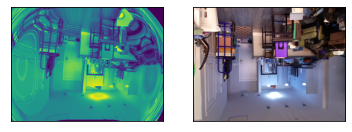

In [60]:
fig, ax = plt.subplots(ncols = 2, figsize = (6,4))
ax[0].imshow(rectified_pair[1])
# ax[0].imshow(stereo_depth_map(rectified_pair),cmap='jet') #cmap='jet'
ax[1].imshow(RGB_imgLeft)

[ax[j].get_yaxis().set_visible(False) for j in range(2)]
[ax[j].get_xaxis().set_visible(False) for j in range(2)]
fig.savefig('image2.png', dpi = 300, bbox_inches = 'tight', transparent = False)

In [ ]:
n = -2
m = n
D1 = np.zeros((image_height,image_width), "uint8")
D1[260-n:615+n,810-m:1060+m] =  1

D2 = np.zeros((image_height,image_width), "uint8")
D2[335-n:620+n,740-m:930+m] =  1

D3 = np.zeros((image_height,image_width), "uint8")
D3[390-n:610+n,770-m:935+m] =  1

D4 = np.zeros((image_height,image_width), "uint8")
D4[420-n:605+n,807-m:947+m] =  1

D5 = np.zeros((image_height,image_width), "uint8")
D5[448-n:610+n,840-m:960+m] =  1

D6 = np.zeros((image_height,image_width), "uint8")
D6[525-n:646+n,915-m:1000+m] =  1

D7 = np.zeros((image_height,image_width), "uint8")
D7[535-n:635+n,930-m:1000+m] =  1

D8 = np.zeros((image_height,image_width), "uint8")
D8[545-n:635+n,940-m:998+m] =  1

binaries = [D1,D2,D3,D4,D5,D6,D7,D8]